----------------------------------------
## Initialisation

### Load modules

In [1]:
import App
import numpy as np

from Tools.DataSet import DataSet

Using TensorFlow backend.


In [2]:
from Data.Challenge2 import DataIO                                 # Challenge2 data loading
from Data.Challenge2.DataIO import DrawingData                     # Import custom data class for distant pickle

from InputFormatter import to_normalized_images as input_formatter
from Tools.CategorigalMapping import CategoricalMapping

cat_mapping = CategoricalMapping(DataIO.get_output_categories())   # Create an output encoder/decoder

### Import model

In [3]:
from Models.Challenge2.CNN2D_2 import Compiler                      # Import a compiler for the model

model_name = 'Challenge2/CNN2D_2'
network_name = None

nn = App.load_model('Models/{}/'.format(model_name), network_name)  # Load the model
nn = Compiler.compile_model(nn)                                     # Compile the model

loading model: Models/Challenge2/CNN2D_2/


----------------------------------------------
## Training

### Data Generators (for continuous data feed)

In [4]:
from Tools.ThreadedGenerator import ThreadedGenerator

# Function instanciating a ThreadedGenerator which will load the subsets corresponding to subsets_indices[]
generator_maker = lambda subsets_indices:\
                      ThreadedGenerator(size = DataIO.get_subsets_size(subsets_indices),
                                        batch_size = 1024,
                                        subset_indices = subsets_indices,
                                        subset_loader = DataIO.load_training_data,
                                        buffer_size = 64,
                                        x_modifier = input_formatter,
                                        y_modifier = lambda labels: np.array([cat_mapping.to_category(label)
                                                                              for label in labels]))

train_generator = generator_maker(list(range(0, 400)))  # Create training image loading generator
val_generator = generator_maker(list(range(400, 450)))   # Create validation image loading generator

dataset = DataSet(train_generator, val_generator)      # Instantiate the DataSet

### LearningRate Reductor

In [5]:
# Create a learning rate reductor
from keras.callbacks import ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                 patience=3, verbose=1, factor=0.5, min_lr=0.000001)

### Train network

In [ ]:
train_history = App.train_model(nn, dataset, 1, 1024, lr_reduction)       # Train the model

Epoch 1/1
gen_iterator_created
gen_iterator_created
31754/38858 [=======================>......] - ETA: 46:59 - loss: 0.1269 - categorical_crossentropy: 0.1269 - categorical_accuracy: 0.9671

Exception in thread Thread-1000:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 66, in _launch
    self.pid = os.fo

31781/38858 [=======================>......] - ETA: 46:59 - loss: 0.1268 - categorical_crossentropy: 0.1268 - categorical_accuracy: 0.9671

In [ ]:
App.evaluate(nn, dataset.val_images, dataset.val_labels)  # Evaluate the model

### Save weights

In [7]:
network_name = 'Main6'
App.save_model(nn, 'Models/{}/'.format(model_name), network_name)  # Save model + (opt) network

## Test

### Load test data

In [4]:
test_images, test_labels = DataIO.load_training_data(480)            
test_images = input_formatter(np.array(test_images))
test_labels = np.array(list(map(cat_mapping.to_category, test_labels)))

### Predict

In [5]:
predictions = App.TestPredictions(test_images,  test_labels)  # Map predictions
App.predict(nn, cat_mapping, predictions)  # Make predictions

99247 predictions: 99224 correct, 23 incorrect


### Plot some predictions

(64, 64)



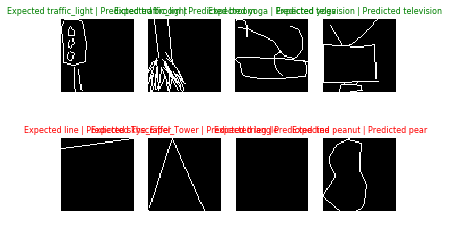

In [6]:

predictions.images = [np.array(np.round(x * 255), np.uint8).reshape(64, 64,) for x in predictions.images]
print(predictions.images[0].shape)
print('')
App.visual_confirmation(predictions, cat_mapping)                                                 # Plot sample of predictions

-------------------------------------------------
## Predictions

### Load prediction data

In [7]:
test_ids, test_images = DataIO.load_prediction_data()
test_images = input_formatter(np.array(test_images))

Loading test dataset from file: Data/Challenge2/sources/test_simplified.csv


### Predict

In [8]:
# Make predictions on the Test data
predictions = App.Predictions(test_images)  # Map predictions
App.predict(nn, cat_mapping, predictions)   # Make predictions

### Get the 3 most probable labels

In [9]:
predictions.results = [cat_mapping.to_label(result, 3) for result in predictions.results]

### Plot some predictions

['megaphone', 'firetruck', 'passport']
['piano', 'cooler', 'house']
['fire_hydrant', 'telephone', 'stove']
['rabbit', 'teddy-bear', 'fan']
['beach', 'hot_tub', 'animal_migration']
['streetlight', 'knee', 'nail']
['rainbow', 'helmet', 'bridge']
['grapes', 'lobster', 'cello']


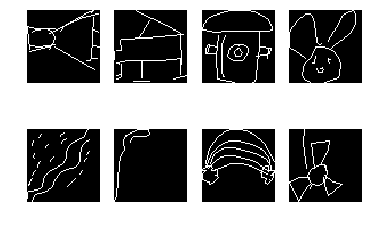

In [12]:
from Tools.Plotting import plot_images
plottable = range(500, 508)
plottable_images = []
plottable_result = []
for i in plottable:
    plottable_images.append(np.array(np.round(predictions.images[i] * 255), np.uint8).reshape(64, 64,))
    plottable_result.append(predictions.results[i])
for cat_list in plottable_result:
    print(cat_list)
plot_images(plottable_images)

### Export predictions

In [11]:
results = {'key_id': test_ids, 'word': ['{0} {1} {2}'.format(pred[0], pred[1], pred[2]) for pred in predictions.results]}
DataIO.save_submission(results)